<a href="https://colab.research.google.com/github/BandaVallary/Movie_Recommendation_System/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Movie Recommendation System

![Alt text](https://github.com/BandaVallary/Movie_Recommendation_System/blob/main/images/movie_img.jpeg?raw=1)

## Summary

In this project, we utilized a dataset from MovieLens, which includes user ratings for movies along with movie metadata (such as titles, genres, and tags). The dataset contains 100,836 user ratings, created by 610 users, with an average of around 3.5 out of 5, indicating a generally positive user response. This data is well suited for developing a recommendation system as it encompasses both collaborative filtering (user-item interactions) and content-based filtering(movie features).

Data preparation involved checking and handling missing values and duplicates and formatting data for anlaysis. We employed **Pandas** for data manipulation, **Scikit-Learn** & **Keras** for preprocessing, and **Seaborn** and **Matplotlib** for data visualization.

For modelling, we used **Surprise** for collaborative filtering. We explored various similarity metrics and models in the Surprise library. Moreover, we used **Tensorflow** & **Keras** to build a neural network that included embedding layers for user and movie indices and fully connected layers to capture interactions. We implemented techniques like early stopping and dropout to mitigate overfitting and fine-tuned the learning rate.

For model validation, we used cross validation with the **cross_validate()** function to validate data across different folds.

The model was evaluated using the **Root Mean Squared Error (RMSE)** metric, with the final model achieving an RMSE of 0.869, suggesting that predicted ratings were off by 0.869 points. A train
-test split of 80% training and 20% testing was used tovalidate the model's performance. Overall the hybrid recommendation system effectively delivers personalized movie suggestions.

## 1. Overview

This project aims to develop a recommendation system that provides personalized movie recommendations based on user ratings. Utilizing the [MovieLens dataset](https://web.archive.org/web/20240828133414/https://grouplens.org/datasets/movielens/latest/) from the GroupLens research lab at the University of Minnesota, the model will be trained on a subset of the dataset containing 100,000 user ratings.

This system can be valuable for streaming platforms and movie enthusiasts, offering tailored movie suggestions to enhance user experience and engagement.The project will involve several steps, including data cleaning, exploratory data analysis, feature engineering, model selection, and evaluation.

Throughout this project, we will also explore the relationships between different variables and their impact on movie recommendations. This will help us gain insights into user preferences and identify potential areas for improvement. Overall, this project has the potential to provide valuable insights and practical applications for the entertainment industry. By developing a recommendation system that can accurately suggest movies, streaming platforms can better engage their users, improve customer satisfaction, and increase viewership.

## 2. Business Understanding

The entertainment industry, particularly streaming platforms, is highly competitive, with companies constantly striving to enhance user engagement and satisfaction. One of the major challenges faced by these platforms is providing personalized content recommendations that keep users engaged and reduce churn rates.

According to recent studies, personalized recommendations can significantly increase user engagement and satisfaction, leading to higher retention rates and increased viewership. This highlights the need for a robust recommendation system that can accurately suggest movies based on user preferences. By building a recommendation system that can provide top 5 movie recommendations to users based on their ratings of other movies, streaming platforms can offer a more tailored viewing experience.

The business value of this project lies in its ability to help streaming platforms improve their content recommendation strategies, increase user satisfaction, and reduce churn rates. By developing a recommendation system that can accurately suggest movies, platforms can better engage their users, leading to increased viewership and subscription renewals. This can provide a competitive edge in the highly competitive entertainment industry, ultimately driving revenue growth and customer loyalty.

#### Objective/ Business Problem:
> ***Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.***

## 3. Data Understanding

The data used in this repository can be found [here](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) . It is the MovieLens dataset from the GroupLens research lab at the University of Minnesota and it contains 100,000 user ratings.

The data is contained in the following files:
1. `movies.csv` - contains information about movies. Each record represents a movie. It has the following columns:
   
> - `movieId` - movie unique identifier.
> - `title` - name of the movie and includes the year of release in parentheses
> - `genres` - category under which a movie falls.

2. `ratings.csv` - contains rating information. Each record represents one rating by one user for one movie. It has the following features:
    
> - `userId` - unique identifier for a user.
> - `movieId` - movie unique identifier.
> - `rating` - rating given by a user for a particular movie on a scale of 1 to 5
> - `timestamp` - represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

3. `tags.csv` - Each row represents one tag applied to one movie by one user, and has the following features:

> - `userId` - unique identifier for a user.
> - `movieId` - movie unique identifier.
> - `tag` - one word user-generated metadata about movies e.g. funny, sad etc
> - `timestamp` - represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

`movieId` are consistent between `ratings.csv`, `tags.csv`, `movies.csv`, and `links.csv`.

`userId` are consistent between `ratings.csv` and `tags.csv`.

## 4. Data Preparation and Cleaning



In this section, we are going to the following:
1. import the necessary libraries
2. Preview data and ensure they are of correct datatypes
3. load our datasets and merge them to have a final unified dataset
4. Check for missing values & handle them
5. Check for duplicates & handle them
   

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357272 sha256=f121baa40eac5e4f2a6a1b0b16e6f2b97a39515495177a7fa75fe2a685626bb1
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [3]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Dot, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping


from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.similarities import cosine, msd, pearson

In [4]:
# load movie data
movie_data = pd.read_csv('/content/movies.csv')
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# load ratings data
ratings = pd.read_csv('/content/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
#
tags = pd.read_csv('/content/tags.csv')
links = pd.read_csv('/content/links.csv')

Below, we merge our `movies.csv` and `ratings.csv` datasets. We do an `inner join` because we only want the rated movies as the recommendation system is based on the ratings provided by users and therefore,if a movie has no ratings it does not contribute to the recommendation process.

In [7]:
# merge datasets
movies_and_ratings = pd.merge(movie_data, ratings, on = 'movieId')
movies_and_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [8]:
# get preview of data
movies_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


Our dataset columns have the correct types, hence no need for type casting.

In [9]:
# check for missing values
movies_and_ratings.isna().sum()

,0
movieId,0
title,0
genres,0
userId,0
rating,0
timestamp,0


In [10]:
# check for duplicates
movies_and_ratings.duplicated().sum()

0

In [11]:
movies_and_ratings.isna().sum()

,0
movieId,0
title,0
genres,0
userId,0
rating,0
timestamp,0


In [12]:
# dropmissing values
movies_and_ratings = movies_and_ratings.dropna(subset = ['userId'])

In [13]:
# drop unneccesary columns
# drop unnecessary columns
movies_and_ratings = movies_and_ratings.drop(['timestamp'], axis=1)

In [14]:
movies_and_ratings.describe()

,movieId,userId,rating
count,100836.000000,100836.000000,100836.000000
mean,19435.295718,326.127564,3.501557
std,35530.987199,182.618491,1.042529
min,1.000000,1.000000,0.500000
25%,1199.000000,177.000000,3.000000
50%,2991.000000,325.000000,3.500000
75%,8122.000000,477.000000,4.000000
max,193609.000000,610.000000,5.000000


The minimum rating given is 0.5 with the maximum at 5.0. About 50% of our movies have a rating of 3.5, about 75% of our movies are rated 4.0.

## 5. Exploratory Data Analysis

### 5.1 Univariate Analysis

In [15]:
avg_ratings = movies_and_ratings.groupby(['movieId', 'title'])['rating'].mean()
avg_ratings

,,rating
movieId,title,
1,Toy Story (1995),3.920930
2,Jumanji (1995),3.431818
3,Grumpier Old Men (1995),3.259615
4,Waiting to Exhale (1995),2.357143
5,Father of the Bride Part II (1995),3.071429
...,...,...
193581,Black Butler: Book of the Atlantic (2017),4.000000
193583,No Game No Life: Zero (2017),3.500000
193585,Flint (2017),3.500000


In [16]:
# Count of the movie ratings
movies_and_ratings.groupby(['movieId', 'title'])['rating'].count()

,,rating
movieId,title,
1,Toy Story (1995),215
2,Jumanji (1995),110
3,Grumpier Old Men (1995),52
4,Waiting to Exhale (1995),7
5,Father of the Bride Part II (1995),49
...,...,...
193581,Black Butler: Book of the Atlantic (2017),1
193583,No Game No Life: Zero (2017),1
193585,Flint (2017),1


In [17]:
# convert to dataframe
ratings_new = pd.DataFrame(avg_ratings)
ratings_new

,,rating
movieId,title,
1,Toy Story (1995),3.920930
2,Jumanji (1995),3.431818
3,Grumpier Old Men (1995),3.259615
4,Waiting to Exhale (1995),2.357143
5,Father of the Bride Part II (1995),3.071429
...,...,...
193581,Black Butler: Book of the Atlantic (2017),4.000000
193583,No Game No Life: Zero (2017),3.500000
193585,Flint (2017),3.500000


In [18]:
ratings_new['num_of_ratings'] = pd.DataFrame(movies_and_ratings.groupby(['movieId', 'title'])['rating'].count())
ratings_new.head()

,,rating,num_of_ratings
movieId,title,,
1,Toy Story (1995),3.920930,215
2,Jumanji (1995),3.431818,110
3,Grumpier Old Men (1995),3.259615,52
4,Waiting to Exhale (1995),2.357143,7
5,Father of the Bride Part II (1995),3.071429,49


#### 5.1.1 - Distribution of Number of Ratings per Movie

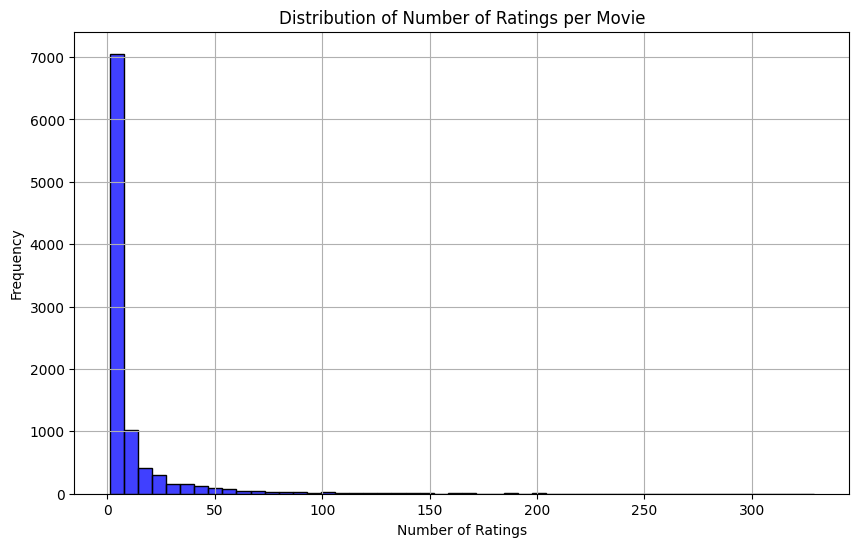

In [19]:
plt.figure(figsize=(10,6))
sns.histplot(x = ratings_new['num_of_ratings'], bins=50, kde=False, color='blue')
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The distribution of the number of ratings per movie is rightly skewed. This implies that majority of the movies have less than 50 ratings with a few having above 100 ratings for a single movie. 50% of the movies have fewer than 50 ratings.

In [20]:
# ratings_new['num_of_ratings'].value_counts(normalize = True)

#### 5.1.2 - Distribution of Ratings

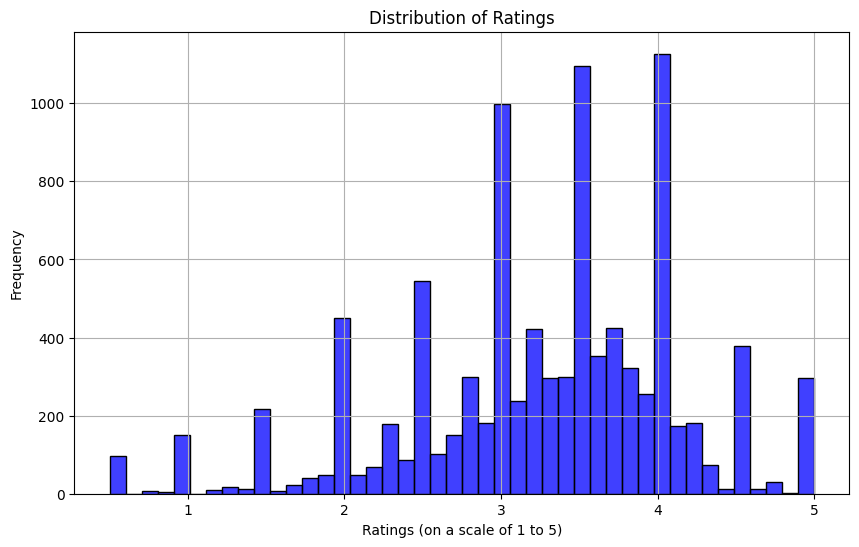

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(x = ratings_new['rating'],  kde=False, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings (on a scale of 1 to 5)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [22]:
# binning
bins = [0, 1, 2, 3, 4, 5]
ratings_new['rating_binned'] = pd.cut(ratings_new['rating'], bins=bins,  right=True)

In [23]:
ratings_new['rating_binned'].value_counts(normalize = True).sort_values()

,proportion
rating_binned,
"(0, 1]",0.026532
"(1, 2]",0.084430
"(4, 5]",0.129576
"(2, 3]",0.266968
"(3, 4]",0.492493


Around 49% of movies receive ratings between 3 and 4. This implies that most movies receive above average ratings and fewer movies receive extremely low or high ratings.

### 5.2 Bivariate Analysis

#### 5.1.2 -  Number of Ratings per User

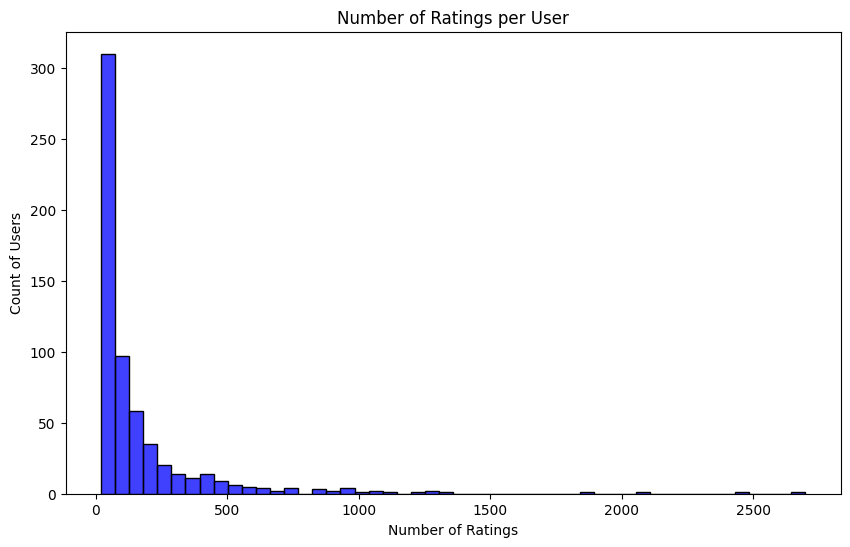

In [24]:
# calculate number of ratings per user
# Number of ratings per user
user_ratings_count = movies_and_ratings.groupby('userId').size()

plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_count, bins=50, kde=False, color = 'blue')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

#### 5.1.2 - Most Popular Movies

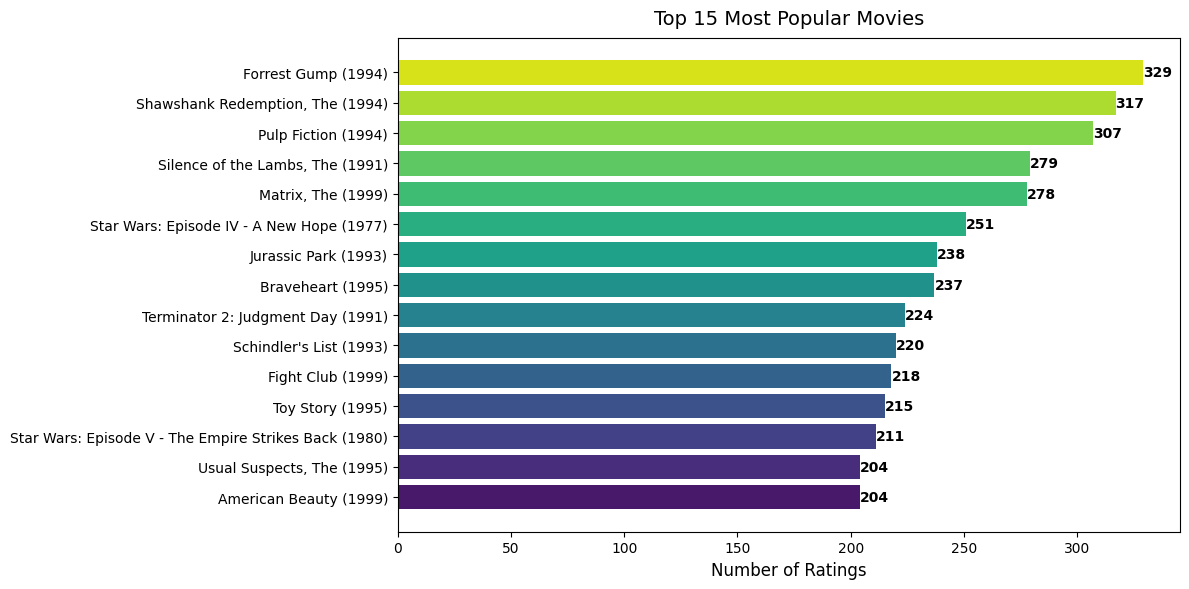


Top 15 Most Rated Movies:
                                                title  number_of_ratings
                               American Beauty (1999)                204
                           Usual Suspects, The (1995)                204
Star Wars: Episode V - The Empire Strikes Back (1980)                211
                                     Toy Story (1995)                215
                                    Fight Club (1999)                218
                              Schindler's List (1993)                220
                    Terminator 2: Judgment Day (1991)                224
                                    Braveheart (1995)                237
                                 Jurassic Park (1993)                238
            Star Wars: Episode IV - A New Hope (1977)                251
                                   Matrix, The (1999)                278
                     Silence of the Lambs, The (1991)                279
                        

In [25]:
# Group by movie title and count the number of ratings
movie_ratings_count = movies_and_ratings.groupby('title')['rating'].count().reset_index()
movie_ratings_count.columns = ['title', 'number_of_ratings']

# Sort by number of ratings and get top 15
top_rated_movies = movie_ratings_count.sort_values('number_of_ratings').tail(15)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.barh(y=range(len(top_rated_movies)), width=top_rated_movies['number_of_ratings'],
                color=sns.color_palette("viridis", len(top_rated_movies)))

# Customize the plot
plt.yticks(range(len(top_rated_movies)), top_rated_movies['title'], fontsize=10)
plt.xlabel('Number of Ratings', fontsize=12)
plt.title('Top 15 Most Popular Movies', fontsize=14, pad=10)

# Add number of ratings to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:,.0f}',  # Format number with commas
             va='center', ha='left', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print the data
print("\nTop 15 Most Rated Movies:")
print(top_rated_movies.to_string(index=False))

#### 5.1.2 - Top 15 Movies by Average Ratings

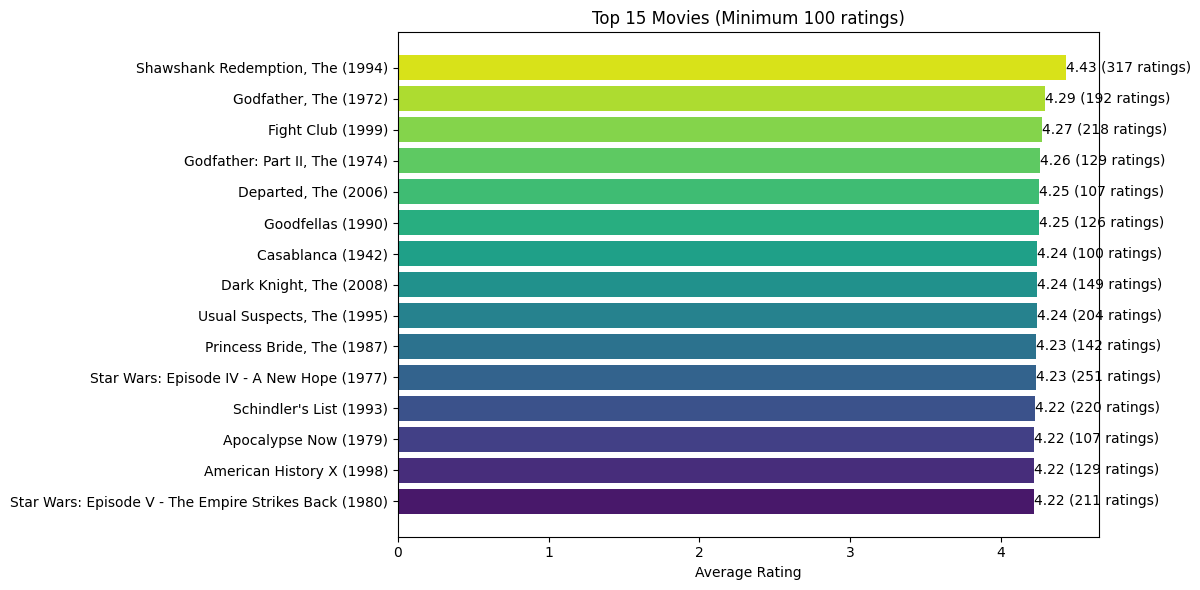


Top 15 Movies Data:
                                                title  avg_rating  num_ratings
Star Wars: Episode V - The Empire Strikes Back (1980)    4.215640          211
                            American History X (1998)    4.217054          129
                                Apocalypse Now (1979)    4.219626          107
                              Schindler's List (1993)    4.225000          220
            Star Wars: Episode IV - A New Hope (1977)    4.231076          251
                           Princess Bride, The (1987)    4.232394          142
                           Usual Suspects, The (1995)    4.237745          204
                              Dark Knight, The (2008)    4.238255          149
                                    Casablanca (1942)    4.240000          100
                                    Goodfellas (1990)    4.250000          126
                                 Departed, The (2006)    4.252336          107
                       Godfathe

In [26]:
# Calculate average rating for each movie and number of ratings
movie_stats = movies_and_ratings.groupby('title').agg({
    'rating': ['mean', 'count']
}).reset_index()

# Flatten the column names
movie_stats.columns = ['title', 'avg_rating', 'num_ratings']

# Filter for movies with a minimum number of ratings
min_ratings = 100
popular_movies = movie_stats[movie_stats['num_ratings'] >= min_ratings]

# Sort by average rating and get top 10
top_movies = popular_movies.sort_values('avg_rating').tail(15)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.barh(y=range(len(top_movies)), width=top_movies['avg_rating'],
                color=sns.color_palette("viridis", len(top_movies)))

# Customize the plot
plt.yticks(range(len(top_movies)), top_movies['title'])
plt.xlabel('Average Rating')
plt.title(f'Top 15 Movies (Minimum {min_ratings} ratings)')

# Add rating annotations to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{top_movies["avg_rating"].iloc[i]:.2f} ({top_movies["num_ratings"].iloc[i]} ratings)',
             va='center', ha='left')

plt.tight_layout()
plt.show()

# Print the data
print("\nTop 15 Movies Data:")
print(top_movies[['title', 'avg_rating', 'num_ratings']].to_string(index=False))

## 6. Data Preparation for Modelling



In [27]:
# prepare data for modelling with surprise
reader = Reader(rating_scale = (0.5, 5.0))
data = Dataset.load_from_df(movies_and_ratings[['userId', 'movieId', 'rating']], reader)

# split data into train and test sets

train_set, test_set = train_test_split(data, test_size = 0.2)

To include the use of `genres` in our recommendation system, we need convert this column into numerical features as machine learning models take numerical data.

Here, we use the `TF-IDF` vectorization to transform the categorical genre data into numerical features that reflect the importance and uniqueness of genres in thie dataset. This will prevent over-weighting common genres. This helps the model to focus on distinctive genres when computing movie similarities.


Calculating the cosine similarity for the entire dataset runs into a `MemoryError` as my system is unable to create the TF-IDF matrix due to its large size. Therefore, we use a subset for this task.

In [28]:
# Preprocessing the genres: replace '|' with space or comma to make it TF-IDF friendly
movies_and_ratings['genres'] = movies_and_ratings['genres'].str.replace('|', ' ')

# compute TF_IDF matrix for movie genres
tfidf = TfidfVectorizer(stop_words='english')
sample_size = 10000  # Adjust this number based on your available memory

movies_sample = movies_and_ratings.sample(n=sample_size, random_state=1)
tfidf_matrix = tfidf.fit_transform(movies_sample['genres'].fillna(''))


# compute cosine similarity between movies based on genres
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## 7. Data Modelling

We are going to explore different modelling approaches:
1. `KNNBasic` model and experiment with the different similarity metrics (cosine, pearson).
2. `KMWithMeans` which takes into account the mean rating of each user.
3. `KNNBaseline` which adds adds in a bias term that is calculated by way of minimizing a cost function.
4. model based CF with SVD
5. Hyperparameter tuning on the SVD model


### 7.1 Baseline Model

Before we begin, it is important to decide which type of collaborative filtering to consider.

Here, we use user-user filtering as it is the lesser of the two. This is in order to reduce computation time and increase training efficiency.

In [29]:
# deciding whether to use item-item Vs user-user similarity. Use whichever is fewer. In this case, users
print("Number of users: ", train_set.n_users, "\n")
print("Number of items: ", train_set.n_items, "\n")

Number of users:  610 

Number of items:  8997 



In [30]:
# define similarity metric to use
similarity_cos = {"name": "cosine", "user_based": True}

# baseline model
baseline_model =KNNBasic(sim_options = similarity_cos)

# fit the model
baseline_model.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [31]:
# cross validation on baseline model
cv_baseline_model = cross_validate(baseline_model, data, n_jobs=-1)

# Get the average RMSE score across all folds
average_rmse = cv_baseline_model['test_rmse'].mean()
print(f"The average rmse score is {average_rmse}")

# make predictions
# baseline_predictions = baseline_model.test(test_set)

The average rmse score is 0.9722547175656121


This implies that the model is off by about 0.973 points for each guess it made for ratings. While it is not bad, there is room for improvement as we are working with a small scale (1 to 5)

### 7.2 Model 2 - Pearson Similarity Metric

In [32]:
similarity_pearson = {"name": "pearson", "user_based" : True}

# fit model
model_pearson = KNNBasic(sim_options = similarity_pearson)

model_pearson.fit(train_set)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [33]:
cv_model_pearson = cross_validate(model_pearson, data, n_jobs=-1)

# get average rmse

avg_rmse_pearson = cv_model_pearson['test_rmse'].mean()

# print rmse
print(f"Average rmse score is : {avg_rmse_pearson}")
# model_pearson_predictions = model_pearson.test(test_set)

Average rmse score is : 0.9730460023636883


The rmse score is 0.974. This implies that the model's predictions are off by about 0.974 points. These two models are identical as they have very close rmse scores.

### 7.3 Model 3 - KNNMeans

In [34]:
model_knn_means  = KNNWithMeans(sim_options = similarity_cos)

# fit model
model_knn_means.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [35]:
# cross validate the model
cv_model_knn_means = cross_validate(model_knn_means, data, n_jobs=-1)

avg_rmse_model_knn_means = cv_model_knn_means['test_rmse'].mean()

print(f"The average rmse is : {avg_rmse_model_knn_means}")

The average rmse is : 0.9006406618381397


This model has an rmse score of 0.90 This is better then the two models before. However, there's room for improvement and so we proceed to using KNNBaseline as it introduces a bias term making it an improvement of the methods explored above.

### 7.4 Model 4 - KNNBaseline

In [36]:
model_knn_baseline = KNNBaseline(sim_options=similarity_cos)

# fit model
model_knn_baseline.fit(train_set)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [37]:
# rmse
cv_model_knn_baseline = cross_validate(model_knn_baseline, data, n_jobs = -1)

avg_rmse_knn_baseline = cv_model_knn_baseline['test_rmse'].mean()

print(f"The average rmse is : {avg_rmse_knn_baseline}")

The average rmse is : 0.8788134667952108


The rmse score for the `KNNBaseline` model is 0.879. This is an improvement from the previous models above. We are looking to further reduce this error, therefore, we try matrix factorization models below. In this case, we use Singular Value Decomposition(SVD) and tune the hyperparameters to get the optimal parameters.

### 7.5 Model 5 - Model based

In [38]:
# use SVD for collaborative filtering
model = SVD()
model.fit(train_set)

In [39]:
# Evaluate the model
cv_model = cross_validate(model, data, n_jobs = -1)

avg_rmse_model = cv_model['test_rmse'].mean()

print(f"The average rmse is : {avg_rmse_model}")

The average rmse is : 0.8739608322885533


This model's rmse score is 0.873. This is a slight improvement from the `KNNBaseline` model. They however seem to be performing similarly.

### 7.6 Model 6 - Hyperparameter Tuning

In [40]:
param_grid= {'n_factors': [50, 100, 150],
         'reg_all': [0.02, 0.05, 0.1]}

gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1, cv = 5, joblib_verbose=5)
gs_model.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.0min finished


In [41]:
gs_model.best_score['rmse']

0.8687319272426111

In [42]:
# Extract the best model from GridSearchCV
best_model = gs_model.best_estimator['rmse']

In [43]:
# fit on model
best_model.fit(train_set)

The model's rmse score is 0.869. This implies that the model's predictions are off by about 0.869 points. This is a slight improvement from the previous models and overally the best.

### 7.7 Model 7 - Using Neural Networks

In [44]:
# Encode user IDs and movie IDs
user_ids = movies_and_ratings['userId'].unique()
movie_ids = movies_and_ratings['movieId'].unique()

In [45]:
user_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
movie_to_index = {movie_id: index for index, movie_id in enumerate(movie_ids)}

movies_and_ratings['userIndex'] = movies_and_ratings['userId'].map(user_to_index)
movies_and_ratings['movieIndex'] = movies_and_ratings['movieId'].map(movie_to_index)

In [46]:
from sklearn.model_selection import train_test_split
# Prepare training data
X = movies_and_ratings[['userIndex', 'movieIndex']]
y = movies_and_ratings['rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [47]:
# Define parameters
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_dim = 50

# Define the neural network model
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# User and movie embeddings
user_embedding = Embedding(num_users, embedding_dim)(user_input)
movie_embedding = Embedding(num_movies, embedding_dim)(movie_input)

# Flatten the embeddings
user_vecs = Flatten()(user_embedding)
movie_vecs = Flatten()(movie_embedding)

# Concatenate user and movie vectors
input_vecs = Concatenate()([user_vecs, movie_vecs])

# Fully connected layers
hidden_layer = Dense(128, activation='relu')(input_vecs)

hidden_layer = (Dropout(0.5))(hidden_layer)
hidden_layer = Dense(64, activation='relu')(hidden_layer)
hidden_layer= (Dropout(0.5))(hidden_layer)
output_layer = Dense(1)(hidden_layer)  # Output layer for predicting ratings

In [48]:
# Create the model
model = Model(inputs=[user_input, movie_input], outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics = [RootMeanSquaredError()] )

In [49]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=5, restore_best_weights=True)
model.fit([X_train['userIndex'], X_train['movieIndex']],
          y_train,
          callbacks = early_stopping,
          epochs=20,
          validation_data=([X_val['userIndex'], X_val['movieIndex']], y_val),
          batch_size=256,
          verbose= 1)

Epoch 1/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 12.1282 - root_mean_squared_error: 3.4797 - val_loss: 3.4784 - val_root_mean_squared_error: 1.8650
Epoch 2/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.4822 - root_mean_squared_error: 1.5693 - val_loss: 0.9799 - val_root_mean_squared_error: 0.9899
Epoch 3/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4837 - root_mean_squared_error: 1.2180 - val_loss: 0.8545 - val_root_mean_squared_error: 0.9244
Epoch 4/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.3736 - root_mean_squared_error: 1.1720 - val_loss: 0.8155 - val_root_mean_squared_error: 0.9031
Epoch 5/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.2915 - root_mean_squared_error: 1.1364 - val_loss: 0.8024 - val_root_mean_squared_error: 0.8958
Epoch 6/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.2411 - root_mean_squared_error: 1.1140 - val_loss: 0.7884 - val_root_mean_squared_error: 0.8879
Epoch 7/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/

In [50]:
# Evaluate the model
loss = model.evaluate([X_test['userIndex'], X_test['movieIndex']], y_test)

631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7967 - root_mean_squared_error: 0.8926


This model achieves an rmse of 0.8876. The predictions are off about 0.88 points.

## 8. Model Evaluation

In [51]:
final_model = best_model

# test final model on test set
final_model_predictions = final_model.test(test_set)

# rmse score for final model.
# get rmse from test set
rmse_final = accuracy.rmse(final_model_predictions)

RMSE: 0.8592


The final model has an rmse of 0.8592 on the test set. This implies that the predictions are off by about 0.8 points on the test data.

### 8.1 Generate Recommendations

In [53]:
# Get predicted ratings for all unrated movies for a user and return their titles
def get_collaborative_recommendations(final_model, user_id, all_movie_ids, user_rated_movie_ids, df, n):
    # Get unrated movies
    unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movie_ids]

    # Predict ratings for the unrated movies
    predictions = [final_model.predict(user_id, movie_id) for movie_id in unrated_movies]

    # Sort the predictions by the estimated rating (descending)
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    # Return top N movie IDs and their predicted ratings along with titles
    recommended_movies = []
    for pred in top_predictions:
        movie_title = df.loc[df['movieId'] == pred.iid, 'title'].values[0]
        recommended_movies.append((pred.iid, movie_title, pred.est))  # movie ID, title, and estimated rating

    return recommended_movies

# Get all unique movie IDs
all_movie_ids = movies_and_ratings['movieId'].unique()

# Get movies rated by user 43
user_rated_movie_ids = movies_and_ratings[movies_and_ratings['userId'] == 43]['movieId'].unique()

# Get recommendations for user id = 43
collaborative_recs = get_collaborative_recommendations(final_model, 43,
    all_movie_ids,
    user_rated_movie_ids,
    movies_and_ratings,
    n=5
)

# Display the collaborative recommendations
for movie_id, title, rating in collaborative_recs:
    print(f'Movie ID: {movie_id}, Title: {title}, Predicted Rating: {rating:.2f}')

Movie ID: 6, Title: Heat (1995), Predicted Rating: 5.00
Movie ID: 16, Title: Casino (1995), Predicted Rating: 5.00
Movie ID: 28, Title: Persuasion (1995), Predicted Rating: 5.00
Movie ID: 50, Title: Usual Suspects, The (1995), Predicted Rating: 5.00
Movie ID: 58, Title: Postman, The (Postino, Il) (1994), Predicted Rating: 5.00


In [54]:
# Function to get top N similar movies based on genres for a given movie
def get_similar_movies(movie_id, df, cosine_sim, user_rated_movie_ids, n):
    movie_idx = movies_and_ratings[movies_and_ratings['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the similar movie indices while avoiding duplicates
    similar_movie_indices = []
    for i in sim_scores[1:]:  # Start from 1 to avoid the original movie
        if len(similar_movie_indices) < n:
            if movies_and_ratings.iloc[i[0]]['movieId'] not in user_rated_movie_ids:
                similar_movie_indices.append(i[0])

    # Return the movie IDs and titles of the similar movies
    similar_movies = movies_and_ratings.iloc[similar_movie_indices][['movieId', 'title']]
    return similar_movies

# Usage
user_rated_movie_ids = movies_and_ratings[movies_and_ratings['userId'] == 1]['movieId'].unique()
recommendations = get_similar_movies(100, movies_and_ratings, cosine_sim, user_rated_movie_ids, n=5)
print(recommendations)

      movieId                     title
1334       25  Leaving Las Vegas (1995)
2937       73    Misérables, Les (1995)
3192      100          City Hall (1996)
5044      170            Hackers (1995)
5213      177  Lord of Illusions (1995)


In [61]:
# helper function to map movie IDs to valid indices in cosine_sim matrix
def get_valid_movie_idx(movie_id, valid_movie_ids):
    try:
        return valid_movie_ids.index(movie_id)  # Find the index of movie_id in valid_movie_ids
    except ValueError:
        return None  # Return None if movie_id is not in valid_movie_ids

In [62]:
# Modifies get_similar_movies function to ensure valid movie_idx
def get_similar_movies(movie_id, df, cosine_sim, valid_movie_ids, n=5):
    movie_idx = get_valid_movie_idx(movie_id, valid_movie_ids)

    if movie_idx is not None and movie_idx < len(cosine_sim):  # Check if the index is valid
        sim_scores = list(enumerate(cosine_sim[movie_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        similar_movies = [df.iloc[i[0]] for i in sim_scores[1:n+1]]  # Skip the first entry (self-similarity)
        return pd.DataFrame(similar_movies)
    else:
        return pd.DataFrame()  # Return an empty df if movie_idx is invalid

In [63]:
# Combine Collaborative Filtering and Content-Based Filtering
def hybrid_recommendation(user_id, n_recommendations=10):
    # Get list of all movies and movies user has already rated
    all_movie_ids = movies_and_ratings['movieId'].unique()
    user_rated_movie_ids = movies_and_ratings[movies_and_ratings['userId'] == user_id]['movieId'].unique()

    # Filter valid movie IDs (within the bounds of the cosine_sim matrix)
    valid_movie_ids = list(all_movie_ids[:10000])  # Limit to the first 10,000 movie IDs

    # Collaborative filtering recommendations (CF)
    collaborative_recs = get_collaborative_recommendations(final_model, user_id, all_movie_ids, user_rated_movie_ids, movies_and_ratings, n=n_recommendations)

    # Filter the collaborative recommendations to include only movie IDs within the first 10,000
    collaborative_recs = [(movie_id, movie_title, predicted_rating) for movie_id, movie_title, predicted_rating in collaborative_recs if movie_id in valid_movie_ids]

    # Create a dictionary to hold hybrid recommendations (weighing CF and CBF)
    hybrid_recs = {}

    # For each movie recommended by CF, boost its score if it's also recommended by CBF
    for movie_id, movie_title, predicted_rating in collaborative_recs:
        # Ensure only movies in the first 10,000 are used in content-based filtering (CBF)
        if movie_id in valid_movie_ids:
            similar_movies = get_similar_movies(movie_id, movies_and_ratings, cosine_sim, valid_movie_ids, n=5)

            # Boost score for movies similar to those recommended by collaborative filtering
            for _, similar_movie in similar_movies.iterrows():
                similar_movie_id = similar_movie['movieId']
                if similar_movie_id in valid_movie_ids:  # Filter similar movies to be within the valid movie IDs
                    if similar_movie_id in hybrid_recs:
                        hybrid_recs[similar_movie_id] += predicted_rating * 0.5  # Combine scores (weighted)
                    else:
                        hybrid_recs[similar_movie_id] = predicted_rating * 0.5

    # Combine the collaborative recommendations and content-based similarity
    for movie_id, _, predicted_rating in collaborative_recs:
        if movie_id in hybrid_recs:
            hybrid_recs[movie_id] += predicted_rating * 1.5  # Gives more weight to collaborative filtering
        else:
            hybrid_recs[movie_id] = predicted_rating * 1.5

    # Sort by the combined scores
    hybrid_recs = sorted(hybrid_recs.items(), key=lambda x: x[1], reverse=True)

    # Get top N recommendations and ensure no duplicates
    top_movie_ids = list(dict.fromkeys([movie_id for movie_id, _ in hybrid_recs[:n_recommendations]]))  # Remove duplicates

    # Return the top N movie titles dropping duplicates
    return movies_and_ratings[movies_and_ratings['movieId'].isin(top_movie_ids)].drop_duplicates('movieId')

In [64]:
# Usage: Get top 10 hybrid recommendations for user 1
recommendations = hybrid_recommendation(user_id=1, n_recommendations=10)

# Display recommendations
print(recommendations[['title', 'genres']])

                                                   title  \
0                                       Toy Story (1995)   
215                                       Jumanji (1995)   
325                              Grumpier Old Men (1995)   
8652                    Shawshank Redemption, The (1994)   
18537  Dr. Strangelove or: How I Learned to Stop Worr...   
20329                                 Rear Window (1954)   
20976      Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)   
23756                   Streetcar Named Desire, A (1951)   
25196                                      Brazil (1985)   
25517                          Lawrence of Arabia (1962)   

                                            genres  
0      Adventure Animation Children Comedy Fantasy  
215                     Adventure Children Fantasy  
325                                 Comedy Romance  
8652                                   Crime Drama  
18537                                   Comedy War  
20329                

## 9. Conclusions

1. Our final model achieved a Root Mean Squared Error (RMSE) of 0.8717 on test data. This implies that the predicted ratings were off by less than one point, on average. This is considered good performance although there's room for improvement.


## 10. Recommendations

1. Address Overfitting: Although dropout layers and early stopping were implemented, the model still showed signs of overfitting. Future work could explore further regularization techniques, such as weight decay or using a simpler model architecture, to generalize better to unseen data.
2. Incorporate additional features such as gender, geographical location, movie director information, actors and so much more to improve model predictions and provide a more personalized recemmendation system.